# Water, wet vegetation and fractional cover polygon drill stack plot

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | Jan 7, 2019 |
| Last edited: | Jan 10, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

__Background:__ Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). The code snippets in this notebook will let you retrieve and plot the [Fractional Cover](https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF) (FC25) data stored in DEA.

__What does this notebook do?:__ This notebook takes a supplied shapefile of a polygon and queries the datacube for WOfS, Fractional Cover and NBART. It calculates thresholded tasselled cap wetness. The results are plotted against each other as a stacked plot for assessing change in wetlands or land cover. 
    
__How to use this notebook:__

A basic understanding of any programming language is desirable but one doesn't have to be an expert Python programmer to manipulate the code to get and display the data.This doc applies to the following Landsat satellites, Fractional Cover bands and the WOfS dataset:

- Landsat 5
- Landsat 7
- Landsat 8
- PV - Photosythetic vegetation
- NPV - Non-Photosythetic vegetation
- BS - Bare Soil
- WOfS Feature Layers (WOFLs)




__Future Work:__ 
- do this by max extent of wetness
- add rainfall for context
        

### import modules


In [2]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry

sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools, RainfallTools

dc = datacube.Datacube(app='tci and wofs')

%load_ext autoreload

%autoreload 2

### Set up polygon

In [3]:
#change the path here if you want a different polygon
#poly_path = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/reeves_lake_for_demo.shp'
poly_path = '/g/data/r78/SA_mound_springs/Big_Blythe_small.shp'

In [4]:
#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

<Figure size 432x288 with 0 Axes>

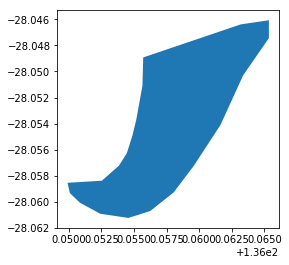

In [5]:
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()
plt.show()

### Set up query

In [6]:
query = {'geopolygon': geom,
         #'time': ('2016-01-01', '2018-06-30')
         #'time': ('2007-01-01', '2007-06-30')
         'time': ('1987-01-01', '2019-01-01')
         }

## Set up datasets

### set cloudmasking threshold and load landsat nbart data

In [7]:
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0.90
ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
        masked_prop=landsat_masked_prop)

Loading ls5 pixel quality
    Loading 278 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 65 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 96 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask the data with our original polygon to remove extra data 

In [8]:
data = ls578_ds
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=False)

In [9]:
#for some reason xarray is not playing nicely with our old masking function
mask_xr = xr.DataArray(mask, dims = ('y','x'))
ls578_ds = data.where(mask_xr==False)

In [10]:
#transform the nbart into tci
tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

### create a masked version of the extent of overthreshold wetness

In [11]:
#select only finite values (over threshold values)
tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

In [12]:
# #reapply the polygon mask
tcw = tcw.where(mask_xr==False)

### load wofls and select only wet pixels

In [13]:
#load wofs
wofls = dc.load(product = 'wofs_albers', like=ls578_ds)

/g/data/v10/public/modules/dea/20181015/lib/python3.6/site-packages/datacube/api/query.py:93: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if like:


In [14]:
#only get wet obs
wetwofl = masking.make_mask(wofls, wet=True)

In [15]:
#match the wofs observations to the nbart
wetwofl=wetwofl.where(wofls.time==ls578_ds.time)

### mask the wofs obs

In [16]:
#mask the wofs obs with the polygon mask
wetwofl = wetwofl.where(mask_xr==False)

### load in fractional cover data

In [17]:
#load the data according to our query
#choose a mask proportion to look for a clear timestep
fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

Loading ls5 pixel quality
    Loading 278 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 65 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 96 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask FC with polygon

In [18]:
fc_ds = fc_ds.where(mask_xr==False)

### mask FC with wetness

In [19]:
fc_ds_noTCW=fc_ds.where(tcw==False)

In [20]:
#set scene to plot
scene =2

<Figure size 432x288 with 0 Axes>

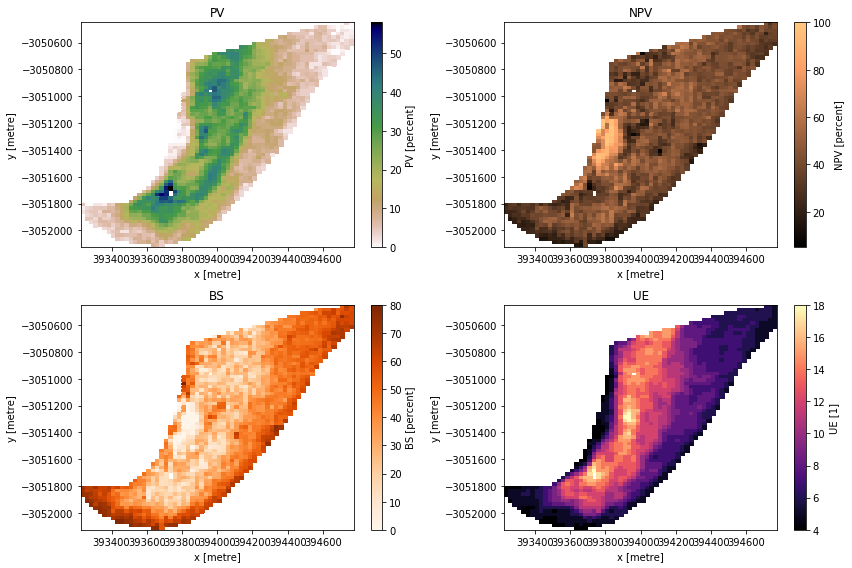

In [21]:
#set up our images on a grid using gridspec
plt.clf()
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
fc_ds_noTCW.PV.isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
fc_ds_noTCW.BS.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
fc_ds_noTCW.NPV.isel(time=scene).plot(cmap='copper')
ax3.set_title('NPV')

ax4=plt.subplot(gs[1,1])
fc_ds_noTCW.UE.isel(time=scene).plot(cmap='magma')
ax4.set_title('UE')

plt.tight_layout()
plt.show()

### Calculate number of pixels in area of interest

In [22]:
#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

In [23]:
mask_xr==0
mask_xr.count(dim=['x','y'])

<xarray.DataArray ()>
array(4154)

In [24]:
#count number of wofs pixels
wofs_pixels = wetwofl.water.sum(dim=['x','y'])

#count percentage of area of wofs
wofs_area_percent = (wofs_pixels/pixels)*100

#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

#calculate percentage area wet
tcw_area_percent = (tcw_pixel_count/pixels)*100

#calculate wet not wofs
tcw_less_wofs = tcw_area_percent-wofs_area_percent

### Calculate the dominant fraction for each pixel in Fractional Cover

In [25]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)

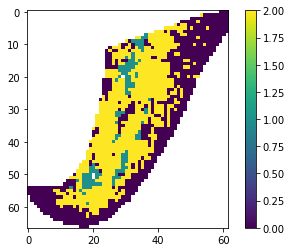

In [26]:
#plot the results to check they look roughly like what we are expecting
plt.clf()
plt.imshow(BSPVNPV[2])
plt.colorbar()

In [27]:
FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

In [28]:
FC_count = FC_dominant.sum(dim=['x','y'])

In [29]:
#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon

Bare_soil_percent=(FC_count.BS/pixels)*100

Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

### Load rainfall data

In [30]:
rain = RainfallTools.load_rainfall(query)
#mask the rain with the polygon mask
rain = rain.where(mask_xr==False)

These rainfall grids have been realigned by the load_rainfall function - if you think this  may be incorrect then check your data and metadata then contact BDunn or VNewey


### Resample the rainfall data 


In [31]:
rain_yrly=rain.resample(time='YS').sum()
rain_yrly = rain_yrly.where(mask_xr==False)

In [47]:
#get 1D rain
rain_flat= rain_yrly.mean(dim=['latitude','longitude','x','y'])
print (rain_flat)
flat_rain=rain_flat.squeeze()

<xarray.Dataset>
Dimensions:   (time: 32)
Coordinates:
  * time      (time) datetime64[ns] 1987-01-01 1988-01-01 ... 2018-01-01
Data variables:
    rainfall  (time) float32 187.69997 197.09999 ... 177.90001 21.199999


In [48]:
flat_rain

<xarray.Dataset>
Dimensions:   (time: 32)
Coordinates:
  * time      (time) datetime64[ns] 1987-01-01 1988-01-01 ... 2018-01-01
Data variables:
    rainfall  (time) float32 187.69997 197.09999 ... 177.90001 21.199999

In [49]:
#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]#,
      #sns.xkcd_rgb["grey"]]

NameError: name 'ax' is not defined

<Figure size 432x288 with 0 Axes>

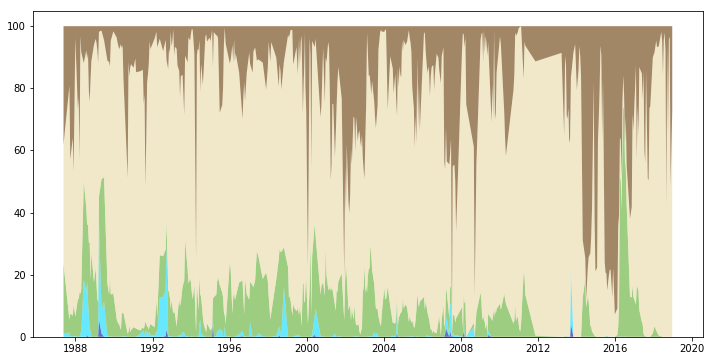

In [50]:
#make a stacked area plot
plt.clf()

fig1, ax1 = plt.subplots(figsize = (12,6))
ax1= plt.stackplot(wofs_area_percent.time.values, 
              wofs_area_percent, 
              tcw_less_wofs, 
              Photosynthetic_veg_percent, 
              NonPhotosynthetic_veg_percent,
              Bare_soil_percent,
              NoData,
              labels=['open water',
                      'wet',
                      'PV',
                      'NPV',
                      'BS'#,
                      #'NoData'
                     ], colors=pal, alpha = 0.6)
#plt.gca().set_ylabel('percentage of area')
lines, labels = plt.gca().get_legend_handles_labels()

#set date ticks every year
years = mdates.YearLocator(2)
yearsFmt = mdates.DateFormatter('%Y')
#ax = plt.gca()
#ax.set_facecolor('xkcd:grey brown')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

#plt.twinx(ax=ax2)
ax2=plt.twinx()
ax2=flat_rain.rainfall.plot.line(ax=ax2, c='black',ls='--', alpha=0.2)

plt.gca().set_ylabel('yearly rainfall mm', color='xkcd:black',alpha=0.4)

plt.title(f'Percentage of area WOfS, Wetness, Fractional Cover ')
# #add a legend and a tight plot box
plt.axis(xmin = query['time'][0], xmax = query['time'][1])#, ymin = 0, ymax = 40)

lines2, labels2 = ax.get_legend_handles_labels()
plt.legend(lines,labels, loc='upper right')
plt.tight_layout()

# #save the figure
plt.savefig('/g/data/r78/rjd547/SA_mound_springs/Big_Blythe_small_all2_wrain.png')#, transparent=True)
# plt.show()

In [51]:
flat_rain.rainfall

<xarray.DataArray 'rainfall' (time: 32)>
array([187.69997 , 197.09999 , 185.89998 ,  96.999985,  57.800003, 282.19998 ,
       210.90001 ,  71.4     , 206.5     ,  54.299995, 164.90004 , 202.59999 ,
        88.09998 , 197.09999 , 202.30002 ,  77.700005, 135.2     , 115.59998 ,
       107.59998 ,  14.000002,  90.09999 , 113.5     , 117.90002 , 227.90001 ,
       173.00003 , 122.700005,  91.69999 ,  81.700005, 122.999985, 259.50012 ,
       177.90001 ,  21.199999], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1987-01-01 1988-01-01 ... 2018-01-01